<a href="https://colab.research.google.com/github/Poofy0103/TrOCR_Fine_tuned/blob/main/Fine_tune_TrOCR_on_self_created_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune TrOCR on the IAM Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), a collection of annotated images of handwritten text.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text.

This figure gives a good overview of the model (from the original paper):

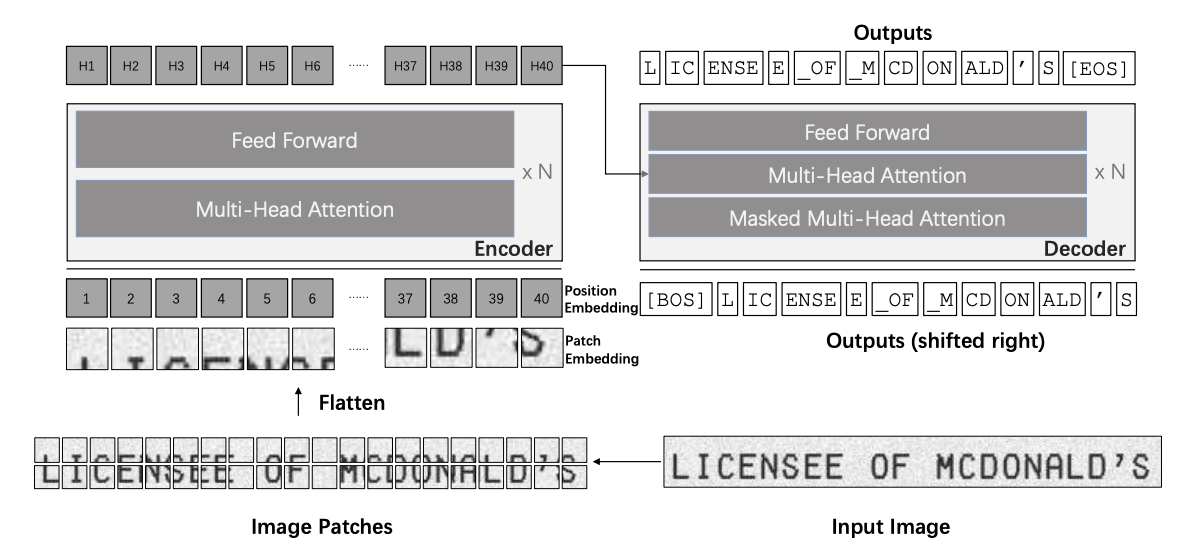

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook.

We will fine-tune the model using native PyTorch.


### **Set-up environment**

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)
* Mltu (for the inference's evaluation metric)
* Huggingface_hub (for logging into the owner of dataset to be able to clone it into colab)

In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.0 MB/s eta 0:00:00


In [3]:
!pip install -q mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.7 MB/s eta 0:00:00


In [4]:
!pip install -q huggingface_hub

In [5]:
from huggingface_hub import hf_hub_download
from huggingface_hub import login
from google.colab import userdata

#Login huggingface through access token (which is redacted as a secret key by Colab)
login(token=userdata.get('TrOCRGit'))
#Download datasets
hf_hub_download(repo_id="Thien0103/test_trocr", filename="crop_images.zip", local_dir = "/content")
hf_hub_download(repo_id="Thien0103/test_trocr", filename="labels_file.zip", local_dir = "/content")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


crop_images.zip:   0%|          | 0.00/56.4M [00:00<?, ?B/s]

labels_file.zip:   0%|          | 0.00/128k [00:00<?, ?B/s]

'/content/labels_file.zip'

In [ ]:
!unzip crop_images.zip -d /content/crop_images
!unzip labels_file.zip -d /content

In [7]:
#Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torch
from datasets import load_metric
from transformers import AdamW
from tqdm.notebook import tqdm
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from mltu.utils.text_utils import ctc_decoder, get_cer
import numpy as np
from torch.utils.data import DataLoader
import glob, os

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr).

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [8]:
os.chdir("/content/labels_file")
metadata = pd.DataFrame(columns=["file_name","text","created_by"])
for file in glob.glob("*.xlsx"):
    df = pd.read_excel(file)
    df = df.astype({"file_name": str, "text": str})
    df["created_by"] = file.rstrip("_words.xlsx")
    metadata = pd.concat([metadata,df])
metadata

,file_name,text,created_by
0,Mai0001.png,Ciavor 10mg Tablet,Mai
1,Mai0002.png,Agomelatine SCP 25mg,Mai
2,Mai0003.png,Blooms The Chemist Agomelatine,Mai
3,Mai0004.png,Pharmacor Lurasidone 20mg,Mai
4,Mai0005.png,Mayzent 2mg,Mai
...,...,...,...
329,Quynh0331.png,(Injection),Quynh
330,Quynh0332.png,Nutrison,Quynh
331,Quynh0333.png,concentrated,Quynh
332,Quynh0334.png,500ml,Quynh


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [9]:
train_df, test_df = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata["created_by"])
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [10]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [11]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/crop_images/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/crop_images/',
                           df=test_df,
                           processor=processor)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2582
Number of validation examples: 646


Let's verify an example from the training dataset:

In [13]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

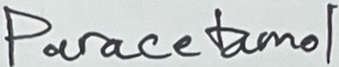

In [14]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Paracetamol


Let's create corresponding dataloaders:

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=25)

### **Predict dataset based on the base model**

In [17]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
val_result_on_train_df = pd.DataFrame(columns=["file_name", "label", "prediction", "CER"])
train_accum_cer = []
root_dir = "/content/crop_images/"
for index, row in train_df.iterrows():
  image = Image.open(root_dir + row['file_name']).convert("RGB")
  pixel_values = processor(images=image, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values, max_new_tokens=4000)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  cer = get_cer(generated_text, row['text'])
  print(f"Image: {row['file_name']}, Label: {row['text']}, Prediction: {generated_text}, CER: {cer}")
  val_result_on_train_df.loc[len(val_result_on_train_df)] = [row['file_name'], row['text'], generated_text, cer]
  train_accum_cer.append(cer)
print(f"Average CER: {np.average(train_accum_cer)}")
val_result_on_train_df.to_csv("/content/base val train result.csv", index=False)

Image: linh98.jpg, Label: Paracetamol, Prediction: Paracetanol, CER: 0.09090909090909091
Image: Mai0126.png, Label: Diamicron, Prediction: Diamieron, CER: 0.1111111111111111
Image: huong150.jpg, Label: Temaze, Prediction: Tenate, CER: 0.3333333333333333
Image: word(thang)_1/thang5.jpg, Label: Capsule, Prediction: Capsule, CER: 0.0
Image: Mai0161.png, Label: Modecate 25mg/ml Amp, Prediction: Modecate using /ml Amp, CER: 0.25
Image: Quynh0111.png, Label: 20, Prediction: 20, CER: 0.0
Image: huong204.jpg, Label: Off, Prediction: off, CER: 0.3333333333333333
Image: Tuan103.jpg, Label: Tablet, Prediction: Tablet, CER: 0.0
Image: word(ha)/ha93.png, Label: Nebules, Prediction: Nebules, CER: 0.0
Image: phat0043.png, Label: Proffessional, Prediction: Professional, CER: 0.07692307692307693
Image: huong313.jpg, Label: Blooms, Prediction: Bloms, CER: 0.16666666666666666
Image: phat0042.png, Label: feeding, Prediction: feeding, CER: 0.0
Image: Quynh0324.png, Label: 150mg/15ml, Prediction: 15 0mg / 1

In [21]:
val_result_on_test_df = pd.DataFrame(columns=["file_name", "label", "prediction", "CER"])
test_accum_cer = []
root_dir = "/content/crop_images/"
for index, row in test_df.iterrows():
  image = Image.open(root_dir + row['file_name']).convert("RGB")
  pixel_values = processor(images=image, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values, max_new_tokens=4000)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  cer = get_cer(generated_text, row['text'])
  print(f"Image: {row['file_name']}, Label: {row['text']}, Prediction: {generated_text}, CER: {cer}")
  val_result_on_test_df.loc[len(val_result_on_test_df)] = [row['file_name'], row['text'], generated_text, cer]
  test_accum_cer.append(cer)
print(f"Average CER: {np.average(test_accum_cer)}")
val_result_on_train_df.to_csv("/content/base val test result.csv", index=False)

Image: word(thang)_1/thang258.jpg, Label: 1g, Prediction: 1 g, CER: 0.5
Image: Tuan248.jpg, Label: Tablet, Prediction: Tablef, CER: 0.16666666666666666
Image: Quynh0327.png, Label: For, Prediction: For, CER: 0.0
Image: huong230.jpg, Label: Finasta, Prediction: Finasta, CER: 0.0
Image: huong174.jpg, Label: Fem, Prediction: Fem, CER: 0.0
Image: huong304.jpg, Label: SCP, Prediction: SCP, CER: 0.0
Image: word(thang)_2/thang161.jpg, Label: 375mg, Prediction: 375 mg, CER: 0.2
Image: word(thang)_1/thang182.jpg, Label: Cardizem, Prediction: Cardizem, CER: 0.0
Image: word(ha)/ha53.png, Label: 3, Prediction: 3, CER: 0.0
Image: Quynh0082.png, Label: IV, Prediction: IV, CER: 0.0
Image: phat0038.png, Label: Aquacel, Prediction: Aquacel, CER: 0.0
Image: huong4.jpg, Label: Diamicron, Prediction: Diamicron, CER: 0.0
Image: linh115.jpg, Label: Amitriptyline, Prediction: Amitripty line, CER: 0.07692307692307693
Image: line(thang)_1/thang146.jpg, Label: Akineton 2mg Tablet, Prediction: A Kineton 2mg Tabl

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [18]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [19]:
cer_metric = load_metric("cer")

<ipython-input-19-00366b855eac>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [20]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [21]:
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 0: 1.5445107479508107


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Validation CER: 0.09480027942243972


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 1: 0.663482482616718


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.05252078563684614


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 2: 0.6162239880515978


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.08340798746070567


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 3: 0.6175051896044841


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.10213413432569343


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 4: 0.5264617107235469


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.06311383126730773


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 5: 0.4280040504840704


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.04670006637507386


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 6: 0.39075197078860724


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.04683630808666164


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 7: 0.4409744401390736


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.06227347302243809


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 8: 0.4524272336409642


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.07942834289914404


  0%|          | 0/104 [00:00<?, ?it/s]

Loss after epoch 9: 0.4000858117181521


  0%|          | 0/26 [00:00<?, ?it/s]

Validation CER: 0.076675960821593


### **Push model to Hugging Face personal repository**

In [22]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-crede

In [23]:
model.push_to_hub("Thien0103/test_trocr")

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Thien0103/test_trocr/commit/55c89bc3fd4c9931044c47a2ee6eb11f240fe10e', commit_message='Upload model', commit_description='', oid='55c89bc3fd4c9931044c47a2ee6eb11f240fe10e', pr_url=None, pr_revision=None, pr_num=None)

### **Reload self-fine-tuning model**

In [24]:
model = VisionEncoderDecoderModel.from_pretrained('Thien0103/test_trocr')

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/303 [00:00<?, ?B/s]

### **Inference and validate on a specific image**

In [31]:
image = Image.open("/content/image_2023_11_23T08_08_59_309Z.png").convert("RGB")
pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
cer = get_cer(generated_text, "Phencyclidine (PCP)")
print(f"Image: /content/thien0001 (1).jpg, Label: Phencyclidine (PCP), Prediction: {generated_text}, CER: {cer}")
display(cer)

Image: /content/thien0001 (1).jpg, Label: Phencyclidine (PCP), Prediction: Phemacylidine (PCT), CER: 0.21052631578947367


0.21052631578947367

### **Inference and validate on multiple images**

In [25]:
val_result_on_train_df = pd.DataFrame(columns=["file_name", "label", "prediction", "CER"])
train_accum_cer = []
root_dir = "/content/crop_images/"
for index, row in train_df.iterrows():
  image = Image.open(root_dir + row['file_name']).convert("RGB")
  pixel_values = processor(images=image, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values, max_new_tokens=4000)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  cer = get_cer(generated_text, row['text'])
  print(f"Image: {row['file_name']}, Label: {row['text']}, Prediction: {generated_text}, CER: {cer}")
  val_result_on_train_df.loc[len(val_result_on_train_df)] = [row['file_name'], row['text'], generated_text, cer]
  train_accum_cer.append(cer)
print(f"Average CER: {np.average(train_accum_cer)}")
val_result_on_train_df.to_csv("/content/fine-tuned val train result.csv", index=False)

Image: linh98.jpg, Label: Paracetamol, Prediction: Paracetamol, CER: 0.0
Image: Mai0126.png, Label: Diamicron, Prediction: Diamicron, CER: 0.0
Image: huong150.jpg, Label: Temaze, Prediction: Temaze, CER: 0.0
Image: word(thang)_1/thang5.jpg, Label: Capsule, Prediction: Capsule, CER: 0.0
Image: Mai0161.png, Label: Modecate 25mg/ml Amp, Prediction: Modecate 25mg/ml Amp, CER: 0.0
Image: Quynh0111.png, Label: 20, Prediction: 20, CER: 0.0
Image: huong204.jpg, Label: Off, Prediction: Off, CER: 0.0
Image: Tuan103.jpg, Label: Tablet, Prediction: Tablet, CER: 0.0
Image: word(ha)/ha93.png, Label: Nebules, Prediction: Nebules, CER: 0.0
Image: phat0043.png, Label: Proffessional, Prediction: Proffessional, CER: 0.0
Image: huong313.jpg, Label: Blooms, Prediction: Blooms, CER: 0.0
Image: phat0042.png, Label: feeding, Prediction: feedingimg, CER: 0.42857142857142855
Image: Quynh0324.png, Label: 150mg/15ml, Prediction: 150mg/15ml, CER: 0.0
Image: linh19.jpg, Label: Olmekar HCT 40/10/25 Tablet, Predictio

In [26]:
val_result_on_test_df = pd.DataFrame(columns=["file_name", "label", "prediction", "CER"])
test_accum_cer = []
root_dir = "/content/crop_images/"
for index, row in test_df.iterrows():
  image = Image.open(root_dir + row['file_name']).convert("RGB")
  pixel_values = processor(images=image, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values, max_new_tokens=4000)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  cer = get_cer(generated_text, row['text'])
  print(f"Image: {row['file_name']}, Label: {row['text']}, Prediction: {generated_text}, CER: {cer}")
  val_result_on_test_df.loc[len(val_result_on_test_df)] = [row['file_name'], row['text'], generated_text, cer]
  test_accum_cer.append(cer)
print(f"Average CER: {np.average(test_accum_cer)}")
val_result_on_test_df.to_csv("/content/fine-tuned val test result.csv", index=False)

Image: word(thang)_1/thang258.jpg, Label: 1g, Prediction: 1g, CER: 0.0
Image: Tuan248.jpg, Label: Tablet, Prediction: Tablet, CER: 0.0
Image: Quynh0327.png, Label: For, Prediction: Fer, CER: 0.3333333333333333
Image: huong230.jpg, Label: Finasta, Prediction: Finasta, CER: 0.0
Image: huong174.jpg, Label: Fem, Prediction: Fem, CER: 0.0
Image: huong304.jpg, Label: SCP, Prediction: SCP, CER: 0.0
Image: word(thang)_2/thang161.jpg, Label: 375mg, Prediction: 325mg, CER: 0.2
Image: word(thang)_1/thang182.jpg, Label: Cardizem, Prediction: Cardizem, CER: 0.0
Image: word(ha)/ha53.png, Label: 3, Prediction: 3, CER: 0.0
Image: Quynh0082.png, Label: IV, Prediction: VV, CER: 0.5
Image: phat0038.png, Label: Aquacel, Prediction: Aquacel, CER: 0.0
Image: huong4.jpg, Label: Diamicron, Prediction: Diamicron, CER: 0.0
Image: linh115.jpg, Label: Amitriptyline, Prediction: Amitriptyline, CER: 0.0
Image: line(thang)_1/thang146.jpg, Label: Akineton 2mg Tablet, Prediction: Aimenton 2mg Tablet, CER: 0.1578947368

### **Inference concurrently (enhancement)**

In [ ]:
# @title
from concurrent.futures import ThreadPoolExecutor
from functools import wraps, partial
import time

In [ ]:
# @title
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [ ]:
# @title
@timeit
def inference(root_dir, file_name, label):
  image = Image.open(root_dir + file_name + ".png").convert("RGB")
  pixel_values = processor(images=image, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  cer = get_cer(generated_text, label)
  print(f"Image: {file_name} Label: {label}, Prediction: {generated_text}, CER: {cer}")
  val_result_df.loc[len(val_result_df)] = [file_name, label, generated_text, cer]
  display(cer)

In [ ]:
# @title
partial_inference = partial(inference, "/content/crop_images/")

In [ ]:
# @title
def inference_concurrently(file_names):
  with ThreadPoolExecutor(max_workers=5) as executor:
    results = executor.map(partial_inference, file_names)
  for result in results:
    print(result)

In [ ]:
# @title
file_names = [(row['file_name'], row['text']) for index, row in df.iterrows()]

In [ ]:
# @title
inference_concurrently(file_names)

TypeError: ignored

In [ ]:
# @title
